In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
from collections import Counter
import cv2
import matplotlib.pyplot as plt 
from datetime import datetime
from multiprocessing import Pool, cpu_count
import time

In [3]:
import os 
os.getcwd()

'/home/jupyter'

In [4]:
path = Path(os.getcwd())

In [5]:
list(path.iterdir())[1:5]

[PosixPath('/home/jupyter/train_images'),
 PosixPath('/home/jupyter/SampleSubmission.csv'),
 PosixPath('/home/jupyter/.ipynb_checkpoints'),
 PosixPath('/home/jupyter/.ssh')]

In [6]:
tr_lab = pd.read_csv(path/'traininglabels.csv')
tr_lab.head(5)

,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000


In [7]:
img_paths = sorted(list((path/'train_images/').iterdir()))

In [8]:
path_aug = path/'Img_aug'
img_path_aug = list(path_aug.iterdir())
img_name_aug = [str(p).split('/')[-1][2:] for p in img_path_aug ]

### Convert image names to paths

In [9]:
tr_lab['aug_path'] = tr_lab['image_id'].apply(lambda x: Path(str(path/'train_images/')+'/'+x))
tr_lab['aug_path'][0:3]

0    /home/jupyter/train_images/img_000002017.jpg
1    /home/jupyter/train_images/img_000012017.jpg
2    /home/jupyter/train_images/img_000022017.jpg
Name: aug_path, dtype: object

In [10]:
tr_lab = tr_lab[['image_id','aug_path','has_oilpalm','score']]

In [11]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

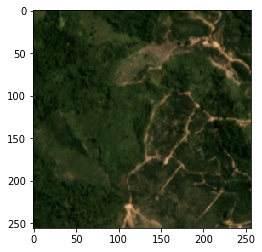

In [12]:
plt.imshow(read_image(img_paths[0]))

In [13]:
# path_aug = path/'Img_aug'
# img_path_aug = list(path_aug.iterdir())
# img_name_aug = [str(p).split('/')[-1][2:] for p in img_path_aug ]

In [14]:
aug = {'image_id': img_name_aug, 'aug_path1': img_path_aug}
aug_df = pd.DataFrame.from_dict(aug)
aug_df.head(3)

,image_id,aug_path1
0,img_064072018.jpg,/home/jupyter/Img_aug/0_img_064072018.jpg
1,img_101522017.jpg,/home/jupyter/Img_aug/1_img_101522017.jpg
2,img_075182017.jpg,/home/jupyter/Img_aug/2_img_075182017.jpg


In [15]:
tr_lab.head(2)

,image_id,aug_path,has_oilpalm,score
0,img_000002017.jpg,/home/jupyter/train_images/img_000002017.jpg,0,0.7895
1,img_000012017.jpg,/home/jupyter/train_images/img_000012017.jpg,0,1.0000


In [16]:
tr_lab = tr_lab.set_index('image_id')
aug_df = aug_df.set_index('image_id')
temp = aug_df.join(tr_lab,on = 'image_id', how = 'left')
aug_df = aug_df.reset_index()
tr_lab = tr_lab.reset_index()

In [17]:
temp = temp.reset_index()
temp.head(2)

,image_id,aug_path1,aug_path,has_oilpalm,score
0,img_064072018.jpg,/home/jupyter/Img_aug/0_img_064072018.jpg,/home/jupyter/train_images/img_064072018.jpg,1.0,1.0
1,img_101522017.jpg,/home/jupyter/Img_aug/1_img_101522017.jpg,/home/jupyter/train_images/img_101522017.jpg,1.0,1.0


In [18]:
temp = temp[['image_id', 'aug_path', 'has_oilpalm', 'score']]

In [19]:
len(temp), len(tr_lab)

(2827, 15244)

In [20]:
final_df = tr_lab.append(temp)

In [21]:
del temp
del tr_lab

### Percent has_oilpalm

In [22]:
np.sum(final_df['has_oilpalm'])/ len(final_df)

0.20851087377566266

In [23]:
final_df['year'] = final_df['image_id'].apply(lambda x: str(x)[-8:-4])

In [24]:
final_df['has_oilpalm'].groupby(by = final_df['year']).sum()/final_df['has_oilpalm'].groupby(by = final_df['year']).count()

year
2017    0.213856
2018    0.203256
ckpo         NaN
Name: has_oilpalm, dtype: float64

In [25]:
final_df = final_df[final_df.isna()['aug_path'] != True]

### Number of palm oil images and count by year

In [26]:
final_df['has_oilpalm'].groupby(by = final_df['year']).sum()

year
2017    1920.0
2018    1848.0
Name: has_oilpalm, dtype: float64

In [27]:
final_df['has_oilpalm'].groupby(by = final_df['year']).count()

year
2017    8978
2018    9092
Name: has_oilpalm, dtype: int64

### Shape of image

In [28]:
final_df = final_df.drop(columns=['image_id'])

In [29]:
final_df = final_df.set_index('aug_path')

In [30]:
final_df.head(2)

,has_oilpalm,score,year
aug_path,,,
/home/jupyter/train_images/img_000002017.jpg,0.0,0.7895,2017
/home/jupyter/train_images/img_000012017.jpg,0.0,1.0000,2017


In [31]:
final_df = final_df.reset_index()

### No Nulls

In [32]:
final_df.isnull().any()

aug_path       False
has_oilpalm    False
score          False
year           False
dtype: bool

### View 10 images

In [33]:
final_df['aug_path'][15:24]

15    /home/jupyter/train_images/img_000232017.jpg
16    /home/jupyter/train_images/img_000242017.jpg
17    /home/jupyter/train_images/img_000252017.jpg
18    /home/jupyter/train_images/img_000272017.jpg
19    /home/jupyter/train_images/img_000282017.jpg
20    /home/jupyter/train_images/img_000302017.jpg
21    /home/jupyter/train_images/img_000312017.jpg
22    /home/jupyter/train_images/img_000322017.jpg
23    /home/jupyter/train_images/img_000332017.jpg
Name: aug_path, dtype: object

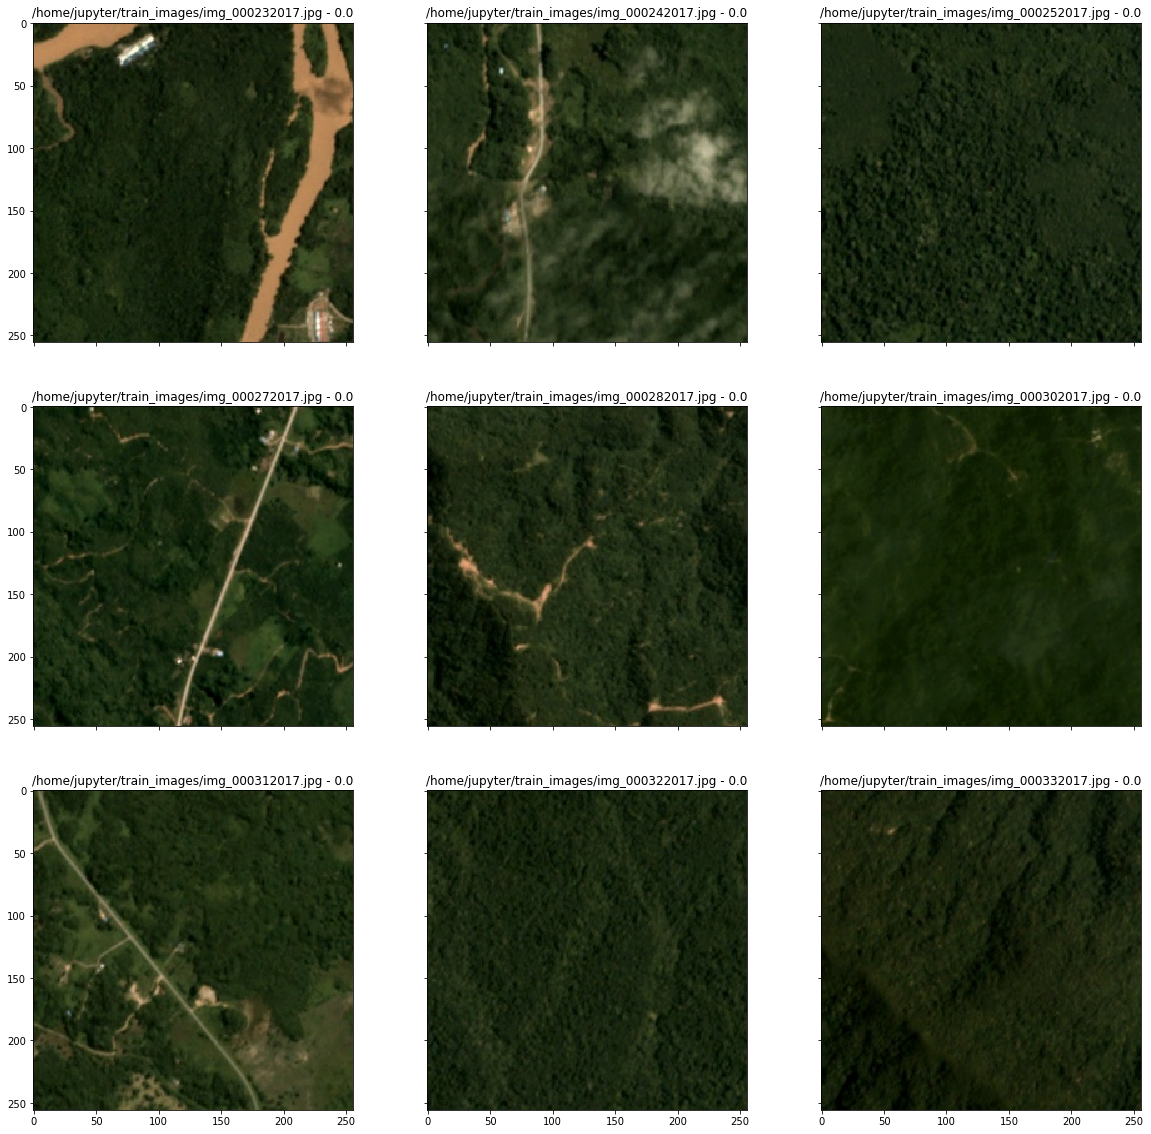

In [34]:
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))
i = 0
for f, l in zip(final_df['aug_path'][15:24],final_df['has_oilpalm'][15:24]):
    img = cv2.imread(str(f))
    ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 3, i % 3].set_title('{} - {}'.format(f, l))
    i += 1
    
plt.show()



### Shuffle and Split data

In [35]:
np.random.seed(3)
mask = np.random.random(len(final_df)) < 0.8
train_df = final_df[mask]
train_df.reset_index(drop=True, inplace=True)
valid_df = final_df[~mask]
valid_df.reset_index(drop=True, inplace=True)

In [36]:
# modified from fast.ai
# Source: https://github.com/yanneta/deep-learning-data-institute/blob/master/lesson6-muti-input.ipynb

import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [65]:
import torch as th
import math
# from torch.utils.data import Sampler
# class Sampler(object):
#     """Base class for all Samplers.
#     Every Sampler subclass has to provide an __iter__ method, providing a way
#     to iterate over indices of dataset elements, and a __len__ method that
#     returns the length of the returned iterators.
#     """

#     def __init__(self, data_source):
#         pass

#     def __iter__(self):
#         raise NotImplementedError

#     def __len__(self):
#         raise NotImplementedError

class StratifiedSampler(torch.utils.data.sampler.Sampler):
    """Stratified Sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, class_vector, batch_size):
        """
        Arguments
        ---------
        class_vector : torch tensor
            a vector of class labels
        batch_size : integer
            batch_size
        """
        self.n_splits = int(class_vector.size(0) / batch_size)
        self.class_vector = class_vector

    def gen_sample_array(self):
        try:
            from sklearn.model_selection import StratifiedShuffleSplit
        except:
            print('Need scikit-learn for this functionality')
        import numpy as np
        
        s = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=0.5)
        X = th.randn(self.class_vector.size(0),2).numpy()
        y = self.class_vector.numpy()
        s.get_n_splits(X, y)

        train_index, test_index = next(s.split(X, y))
        return np.hstack([train_index, test_index])

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)

In [61]:
class PalmOil(Dataset):
    def __init__(self, df, transforms=False, sz=256, test = False):
        self.path_to_images = list(df['aug_path'])
        self.transforms = transforms
        self.df = df
        self.test = test
        self.sz = sz
        self.sz2 = int(sz*1.05)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        path = self.df['aug_path'][idx]
        if not self.test:
            y = self.df['has_oilpalm'][idx]
        else:
            y = str(path).split('/')[-1]

        x = cv2.imread(str(path)).astype(np.float32)/255
        if self.transforms:
            x = cv2.resize(x, (self.sz2, self.sz2))
            x = random_crop(x, self.sz, self.sz)
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.8: x = np.fliplr(x).copy() 
        else:
            x = cv2.resize(x, (self.sz, self.sz))
        return np.rollaxis(x, 2), y

In [62]:
# train should be transformed, validation should not be transformed
train_ds = PalmOil(train_df,transforms=False, sz=128, test = False)
valid_ds = PalmOil(valid_df,transforms=False , sz=128, test = False)

In [63]:
train_labels = [train_ds[i][1] for i in range(len(train_ds))]
valid_labels = [valid_ds[i][1] for i in range(len(valid_ds))]

In [66]:
batch_size = 64
y = torch.LongTensor(train_labels)
sampler = StratifiedSampler(class_vector=y, batch_size=batch_size)

train_dl = DataLoader(train_ds, batch_size=batch_size,num_workers=4, sampler = sampler, pin_memory=True)

y = torch.LongTensor(valid_labels)
sampler = StratifiedSampler(class_vector=y, batch_size=batch_size)

valid_dl = DataLoader(valid_ds, batch_size=batch_size,num_workers=4, sampler = sampler, pin_memory=True)

-2.866229874878914


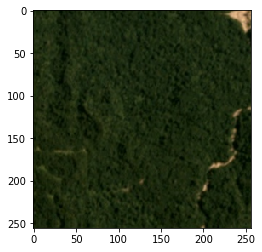

In [79]:
im = read_image(train_df['aug_path'][1])
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot, cmap='gray')

In [80]:
class Net(nn.Module):
    def __init__(self, num_classes=8):
        super(Net, self).__init__()
        resnet = models.resnet50(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(2048)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 2)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        x = nn.Dropout(0.4)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = nn.Dropout(0.4)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [81]:
model = Net().cuda()
train_on_gpu = True

In [82]:
def get_optimizer(model, lr = 1e-3,  momentum=0.9 ):
    """
    Initialize optimizer with the learning rate passed
    """
    optim = torch.optim.SGD([
    {'params': model.top_model[0:4].parameters(), 'lr': lr/10, 'momentum': 0.9 },
    {'params': model.top_model[4:8].parameters(), 'lr ':lr/3 , 'momentum':0.9 },
    {'params': model.bn1.parameters()},
    {'params': model.bn2.parameters()},  
    {'params': model.fc1.parameters()},
    {'params': model.fc2.parameters()}        
], lr=lr, momentum=0.9 )
    
    return optim

def get_scheduler(optimizer, lr = 0.01):
    """
    Return Cosine Annealed learning rates
    """
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 128*2 , eta_min=lr/10)
    return scheduler

def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))



In [83]:
def LR_range_finder(train_on_gpu,model, train_dl, lr_low=1e-5, lr_high=1, epochs=2):
    losses = []
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    
    for i in range(epochs):
        for x,y in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x, y = x.cuda().float(), y.cuda().long()
            out = model(x)
            m = nn.LogSoftmax()
            l = nn.NLLLoss(weight = torch.tensor([1.0,4.0]).cuda())
            loss = l(m(out), y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1  

            
    return lrs, losses

In [84]:
lrs, losses = LR_range_finder(train_on_gpu,model, train_dl, lr_low=1e-7, lr_high= 0.1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


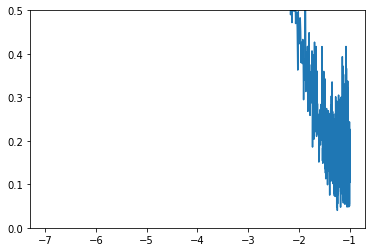

In [85]:
plt.plot([np.log10(l) for l in lrs], losses)
plt.ylim((0,0.5))
plt.show()


In [87]:
import numpy as np
from sklearn.metrics import roc_auc_score
def val_metrics(train_on_gpu , model, valid_dl):
    """
    Calculate the accuracy on validation set with weights trained above
    """
    model.eval()
    total = 0
    sum_loss = 0
    total_correct = 0 
    auc = []
    y_pred = []
    y_orig = []
    for i, (x, y) in enumerate(valid_dl):
        batch = y.shape[0]
        x, y = x.cuda().float(), y.cuda().long()
        out = model(x)
        total_correct += correct(out, y)
        m = nn.LogSoftmax()
        l = nn.NLLLoss(weight = torch.tensor([1.0,4.0]).cuda())
        loss = l(m(out), y)
        sum_loss += batch*(loss.item())
        total += batch
        out =  torch.exp(out)
        preds,_ = torch.max(out, 1)
        preds = preds.detach().cpu().numpy()
        y = y.cpu().numpy()
        
        y_pred.extend(preds)
        y_orig.extend(y)
        
    auc = roc_auc_score(y_orig, y_pred)
    
    print("val loss , accuracy and auc", round(sum_loss/total,5), round(total_correct/total,5) , round(auc,5) )
    return (sum_loss/total, total_correct/total, auc )

In [88]:
def correct(preds, targs):
    _,preds = torch.max(preds, 1)
    return preds.eq(targs).sum().item()


def train(train_on_gpu,model, train_dl, valid_dl, epochs=4, name = str('temp'), lr = 0.01):
    """
    Train the given network, save the model weights when accuracy is lowest, return average loss across epochs
    """
    acc = 0
    for j in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        """
        if i % 10 == 0:
            torch.save(model.state_dict(), 'Resnet_1.pth')
            
        """
            
        for i, (x, y) in enumerate(train_dl):
            #print(x.shape, y.shape)
            optim = get_optimizer(model,lr)    
            #scheduler = get_scheduler(optimizer)
            batch = y.shape[0]
            # move tensors to GPU if CUDA is available
            x, y = x.cuda().float(), y.cuda().long()
            # forward pass: compute predicted outputs by passing inputs to the model
            out = model(x)
            # calculate the batch loss
            m = nn.LogSoftmax()
            l = nn.NLLLoss(weight = torch.tensor([1.0,4.0]).cuda())
            loss = l(m(out), y)
            # set the gradients for tensors to zero to prevent gradient accumulation
            optim.zero_grad()
            # backward pass
            loss.backward()
            # Update parameters
            optim.step()
            #scheduler.step()
            # update train loss and total images processes
            total += batch
            sum_loss += batch*(loss.item())
            
        print("train loss", sum_loss/total)
        # Save the model weights which has lowest validation accuracy
        val_loss, accuracy, auc = val_metrics(train_on_gpu , model, valid_dl)
        if auc > acc:
            torch.save(model.state_dict(), name)
        acc = auc
            
    return sum_loss/total

In [89]:
from datetime import datetime
start = datetime.now() 
loss = train(train_on_gpu, model, train_dl, valid_dl, epochs = 5, name = str('temp'), lr = 1e-2)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of Train")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


train loss 0.14759440683473687


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


val loss , accuracy and auc 0.11819 0.95613 0.7288
train loss 0.1441998427985585
val loss , accuracy and auc 0.12041 0.95949 0.71515
train loss 0.13014065910632808
val loss , accuracy and auc 0.11221 0.96228 0.70684
train loss 0.13383083639225682
val loss , accuracy and auc 0.11004 0.96312 0.72265
train loss 0.12063122295410307
val loss , accuracy and auc 0.11185 0.96424 0.69976
----End of Train


In [90]:
from datetime import datetime
start = datetime.now() 
loss = train(train_on_gpu, model, train_dl, valid_dl, epochs = 5, name = str('temp'), lr = 1e-2)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of Train")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


train loss 0.12553149254285773


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


val loss , accuracy and auc 0.11405 0.96368 0.68045
train loss 0.12101191473845475
val loss , accuracy and auc 0.10398 0.96256 0.69916
train loss 0.11826443099106052
val loss , accuracy and auc 0.11139 0.96004 0.71005
train loss 0.12076742539018934
val loss , accuracy and auc 0.10627 0.962 0.70031
train loss 0.11476475610063236
val loss , accuracy and auc 0.10966 0.95893 0.72742
----End of Train


In [91]:
from datetime import datetime
start = datetime.now() 
loss = train(train_on_gpu, model, train_dl, valid_dl, epochs = 10, name = str('temp'), lr = 1e-2)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of Train")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


train loss 0.1185802183245808


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


val loss , accuracy and auc 0.09969 0.96703 0.68683
train loss 0.10731994728792668
val loss , accuracy and auc 0.0917 0.96899 0.67522
train loss 0.10461355640622541
val loss , accuracy and auc 0.10217 0.96368 0.6556
train loss 0.10626340275637425
val loss , accuracy and auc 0.10345 0.9634 0.67297
train loss 0.11357535032532196
val loss , accuracy and auc 0.1 0.96312 0.6634
train loss 0.10860355371884016
val loss , accuracy and auc 0.09724 0.96479 0.70681
train loss 0.10936930187220825
val loss , accuracy and auc 0.08896 0.96954 0.69889
train loss 0.10520076285578533
val loss , accuracy and auc 0.10093 0.96088 0.64264
train loss 0.10611934271027242
val loss , accuracy and auc 0.09223 0.96731 0.66547
train loss 0.1046364532293769
val loss , accuracy and auc 0.08851 0.96591 0.69182
----End of Train


In [92]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [93]:
unfreeze(model, 7)
unfreeze(model, 6)
from datetime import datetime
start = datetime.now() 
loss = train(train_on_gpu, model, train_dl, valid_dl, epochs = 5, name = str('temp'), lr = 1e-3)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of Train")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


train loss 0.08770669736564529


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


val loss , accuracy and auc 0.05167 0.98016 0.67957
train loss 0.06264305551775526
val loss , accuracy and auc 0.03747 0.98854 0.6778
train loss 0.049588642284848924
val loss , accuracy and auc 0.03023 0.9891 0.7476
train loss 0.04099284690656254
val loss , accuracy and auc 0.02619 0.99357 0.70452
train loss 0.035639729683654614
val loss , accuracy and auc 0.02204 0.99106 0.80203
----End of Train


In [94]:
# unfreeze(model, 7)
# unfreeze(model, 6)
from datetime import datetime
start = datetime.now() 
loss = train(train_on_gpu, model, train_dl, valid_dl, epochs = 5, name = str('temp'), lr = 1e-4)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of Train")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


train loss 0.03167648800173736


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


val loss , accuracy and auc 0.0192 0.99581 0.69707
train loss 0.03230135648150608
val loss , accuracy and auc 0.02135 0.99106 0.76056
train loss 0.031921418192709966
val loss , accuracy and auc 0.02306 0.99274 0.79737
train loss 0.03158801296609799
val loss , accuracy and auc 0.02269 0.99469 0.6794
train loss 0.02904453610067029
val loss , accuracy and auc 0.0207 0.99301 0.81577
----End of Train


### ------------------------------------------------------------------- ###
## Updated with Stratified Sampling ##

In [74]:
unfreeze(model, 5)
from datetime import datetime
start = datetime.now() 
loss = train(train_on_gpu, model, train_dl, valid_dl, epochs = 5, name = str('temp'), lr = 1e-5)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of Train")

train loss 0.047247478419315696
val loss and accuracy 0.053207220094149424 0.9824328803447133
train loss 0.04463202840991887
val loss and accuracy 0.04654730577361398 0.9854159761352337
train loss 0.0467697924055162
val loss and accuracy 0.0558502320268117 0.9824328803447133
train loss 0.044954642569364794
val loss and accuracy 0.055217692047545244 0.9837587006960556
train loss 0.04397531935170206
val loss and accuracy 0.05083651457168347 0.9827643354325489
----End of Train


In [75]:
unfreeze(model, 5)
from datetime import datetime
start = datetime.now() 
loss = train(train_on_gpu, model, train_dl, valid_dl, epochs = 5, name = str('temp'), lr = 1e-7)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of Train")

train loss 0.0429534097913163
val loss and accuracy 0.05539309914524207 0.9854159761352337
train loss 0.04437741523889935
val loss and accuracy 0.04768821693411085 0.9827643354325489
train loss 0.04542696430647624
val loss and accuracy 0.05700657040098071 0.9824328803447133
train loss 0.04501570382063237
val loss and accuracy 0.052098989797855474 0.9854159761352337
train loss 0.04249245612297859
val loss and accuracy 0.049499922323037265 0.9827643354325489
----End of Train


In [76]:
# unfreeze(model, 5)
from datetime import datetime
start = datetime.now() 
loss = train(train_on_gpu, model, train_dl, valid_dl, epochs = 3, name = str('temp'), lr = 1e-6)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of Train")

train loss 0.0430273551565787
val loss and accuracy 0.05154814230593617 0.9847530659595625
train loss 0.04457057199488198
val loss and accuracy 0.0551193470112488 0.9837587006960556
train loss 0.042707860148078806
val loss and accuracy 0.04818516990424862 0.9844216108717269
----End of Train


In [77]:
unfreeze(model, 4)
unfreeze(model, 3)
from datetime import datetime
start = datetime.now() 
loss = train(train_on_gpu, model, train_dl, valid_dl, epochs = 10, name = str('temp'), lr = 1e-5)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of Train")

train loss 0.048096304255751496
val loss and accuracy 0.053742851171720334 0.9830957905203845
train loss 0.04663099741576988
val loss and accuracy 0.05348109115343597 0.9830957905203845
train loss 0.04458143188102229
val loss and accuracy 0.04926714225047702 0.9844216108717269
train loss 0.0438610770145456
val loss and accuracy 0.051134077175824424 0.9874047066622472
train loss 0.04531857016686745
val loss and accuracy 0.048238334066629966 0.9854159761352337
train loss 0.0411192999258936
val loss and accuracy 0.04764063010794223 0.9854159761352337
train loss 0.0456231589736957
val loss and accuracy 0.05151026959959782 0.9850845210473981
train loss 0.04350631162150613
val loss and accuracy 0.04844325478103803 0.9854159761352337
train loss 0.04171066206864756
val loss and accuracy 0.04693661235522307 0.9860788863109049
train loss 0.04393255756910864
val loss and accuracy 0.04853429060761487 0.9844216108717269
----End of Train


In [78]:
from datetime import datetime
start = datetime.now() 
loss = train(train_on_gpu, model, train_dl, valid_dl, epochs = 5, name = str('temp'), lr = 1e-4)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of Train")

train loss 0.04376640885888508
val loss and accuracy 0.04927834365634204 0.9864103413987405
train loss 0.044184060159918624
val loss and accuracy 0.0507557799296937 0.98342724560822
train loss 0.04460502748663142
val loss and accuracy 0.05122062198405318 0.9850845210473981
train loss 0.0398960114500263
val loss and accuracy 0.05281786899674124 0.98342724560822
train loss 0.04298061810033518
val loss and accuracy 0.044943053901373334 0.9847530659595625
----End of Train


In [79]:
unfreeze(model, 3)
unfreeze(model, 2)
unfreeze(model, 1)
unfreeze(model, 0)
from datetime import datetime
start = datetime.now() 
loss = train(train_on_gpu, model, train_dl, valid_dl, epochs = 5, name = str('temp'), lr = 1e-4)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of Train")

train loss 0.04126648521388241
val loss and accuracy 0.04662107521180961 0.9850845210473981
train loss 0.03963256120644668
val loss and accuracy 0.05047747074204405 0.9840901557838913
train loss 0.04115841587498288
val loss and accuracy 0.04740866139545953 0.9857474312230693
train loss 0.03848715940738068
val loss and accuracy 0.048729114098623176 0.9844216108717269
train loss 0.03971603234412629
val loss and accuracy 0.046566000490402756 0.9850845210473981
----End of Train


In [80]:
from datetime import datetime
start = datetime.now() 
loss = train(train_on_gpu, model, train_dl, valid_dl, epochs = 5, name = str('temp'), lr = 1e-2)
end = datetime.now()
t = 'Time elapsed {}'.format(end - start)
print("----End of Train")

train loss 0.03898282404316238
val loss and accuracy 0.034638046220631484 0.9903878024527677
train loss 0.024049187809221814
val loss and accuracy 0.032648624209603766 0.9887305270135897
train loss 0.01568537327023961
val loss and accuracy 0.03088372815517665 0.9887305270135897
train loss 0.012976301509048813
val loss and accuracy 0.02982926396372147 0.9913821677162744
train loss 0.010769781606072528
val loss and accuracy 0.03205454632078684 0.99171362280411
----End of Train


In [86]:
path

PosixPath('/home/jupyter')

In [89]:
TEST_PATH_1 = path/'leaderboard_test_data'
TEST_PATH_2 = path/'leaderboard_holdout_data'

In [90]:
X_test_path_1 = np.array(list(TEST_PATH_1.iterdir())).reshape(-1, 1)
X_test_path_2 = np.array(list(TEST_PATH_2.iterdir())).reshape(-1, 1)
X_test_path = np.concatenate([X_test_path_1, X_test_path_2])
X_test_path.shape

(6534, 1)

In [91]:
X_test_path = pd.DataFrame(X_test_path,columns=['image_id'])

In [92]:
X_test_path.head(2), train_df.head(2)

(                                            image_id
 0  /home/jupyter/leaderboard_test_data/img_034232...
 1  /home/jupyter/leaderboard_test_data/img_111052...,
                                        aug_path  has_oilpalm   score  year
 0  /home/jupyter/train_images/img_000002017.jpg          0.0  0.7895  2017
 1  /home/jupyter/train_images/img_000012017.jpg          0.0  1.0000  2017)

In [93]:
test = PalmOil(X_test_path, transforms=False, sz=128, test=True)
test_dl = DataLoader(test, batch_size=batch_size)

KeyError: 'aug_path'

In [100]:
X, paths = next(iter(test))
X.shape, paths

((3, 128, 128), 'img_034232018.jpg')

In [82]:
model = Net().cuda()
model.load_state_dict(torch.load('temp'))

In [83]:
out = []
fpaths = []

model.eval()
for X, path in test_dl:
    X = X.float().cuda()
    y_hat = model(X)
    _, pred = torch.max(y_hat, 1)
    out.append(pred)
    fpaths.append(path)

NameError: name 'test_dl' is not defined

In [104]:
out = [t.cpu().numpy() for t in out]
out = np.concatenate(out).ravel()
fpaths = np.concatenate(fpaths).ravel()

In [105]:
out.shape, fpaths.shape

((6534,), (6534,))

In [107]:
import csv
pred_out = sorted(list(zip(fpaths, out)), key=lambda x: x[0])

with open('test_output.csv','w') as f:
    csv_out = csv.writer(f)
    csv_out.writerow(['image_id', 'has_oilpalm'])
    for row in pred_out:
        csv_out.writerow(row)
